This notebook aims to conduct data-preprocessing steps for our PD Model, specific to machine learning. The following will be conducted. 
- Feature Engineering / Creation 
- Outlier / Skewness Detection & Treatment 
- Feature Selection (WoE & IV)
- Multicollinearity Handling 
- Low Variance Filter 
- Master Table for PD Production 

# 0. Import Libraries 

In [89]:
# Import function to start Spark
from init_spark import start_spark
spark = start_spark()

from pyspark.sql.functions import (
    col, when, count, desc, isnan, isnull, lit, length, trim, lower, upper, to_date, concat_ws,  regexp_extract, sum 
)

from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, IntegerType, DateType, NumericType
)

25/07/04 14:39:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [90]:

# Check if Gold Delta is accessible for subsequent model building 
df = spark.read.format("delta")\
    .load("../data/gold/medallion_cleaned_lc_data_b4_model")
    
df.limit(10).toPandas()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default_status
0,69532609,15000.0,15000.0,36,9.80,482.61,B,6,OWN,65000.00,...,6.0,93.3,75.0,0.0,0.0,93750.0,46567.0,19000.0,44150.0,1
1,68721741,19200.0,19200.0,36,9.80,617.73,B,6,OWN,62500.00,...,0.0,100.0,27.3,0.0,0.0,60979.0,16221.0,22200.0,38779.0,0
2,69645747,13800.0,13800.0,36,12.88,464.18,C,6,OWN,30000.00,...,1.0,100.0,20.0,0.0,0.0,32800.0,12892.0,32800.0,0.0,0
3,69979570,8000.0,8000.0,36,10.78,261.08,B,6,RENT,29400.00,...,5.0,82.4,66.7,0.0,0.0,33900.0,14270.0,7300.0,0.0,0
4,69473439,25000.0,25000.0,36,5.32,752.87,A,6,MORTGAGE,180000.00,...,1.0,96.2,20.0,0.0,0.0,708560.0,18418.0,57500.0,21060.0,0
5,70090118,25000.0,25000.0,60,17.27,624.95,D,6,RENT,83471.68,...,2.0,100.0,87.5,0.0,0.0,69311.0,55658.0,21600.0,18192.0,1
6,69654235,19950.0,19950.0,36,16.59,707.21,D,6,RENT,37000.00,...,2.0,100.0,0.0,0.0,0.0,74700.0,29399.0,18100.0,24000.0,0
7,69635724,25000.0,25000.0,60,18.99,648.38,E,6,MORTGAGE,40992.00,...,1.0,93.3,100.0,0.0,1.0,185605.0,12535.0,7700.0,11205.0,0
8,69493668,15000.0,15000.0,36,7.91,469.43,A,6,OWN,51500.00,...,2.0,100.0,66.7,0.0,0.0,38990.0,26787.0,14100.0,12090.0,0
9,70010559,10000.0,10000.0,36,6.99,308.73,A,6,MORTGAGE,36000.00,...,1.0,94.6,0.0,0.0,0.0,181967.0,27119.0,46600.0,18362.0,0


# 1. Feature Engineering
### 1.1 Obtaining Interaction Features 
Now, I will be manually inspecting each column, to check if I can create any interaction features. Interaction features capture the joint effect of features, e.g. When a borrower has high `loan_amnt`, it seems OK. When he has a low `income`, he might have a higher risk. But when he has both a high `loan_amnt` and a low `income`, this may be a huge red flag. As such, combining features is extremely important for credit risk modeling. 
<br>

First, a common derived feature in credit risk is the credit history length of the borrower at the time of loan issuance. Normally, it would be safe to say that loans with borrowers with a longer credit history has a lower probability of default. Hence, this can be taken into account as 1 of the features of the dataset. We can compute this as the difference between `issue_d` and `earliest_cr_line`. 

In [91]:
import pyspark.sql.functions as F  

df = df.withColumn('credit_history_years',    F.months_between(F.col('issue_d'), F.col('earliest_cr_line')) / 12   )

Second, it seems that we have 2 features related to FICO Scores: `fico_range_low` and `fico_range_high`. Upon further research, these features do not represent the lowest and highest scores ever recorded for a borrower, but rather the lower and upper bounds of a small range in which the borrower’s actual FICO score falls. Banks record these due to privacy concerns, through a 5 point window, as shown below. As such, it seems that we just need to average these 2 values, to minimise redundancy and multicollinearity. The same applies for `last_fico_range_high` and `last_fico_range_low`, we shall average them out first, since any multicollinearity will be detected later on anyways.

In [92]:
df = df.withColumn('fico_score',  (col('fico_range_low') + col('fico_range_high')) / 2  )
df = df.drop( col("fico_range_low")   , col('fico_range_high') ) 

# Last Credit Pull FICO Score 
df = df.withColumn('last_fico_score',  (col('last_fico_range_low') + col('last_fico_range_high')) / 2  )
df = df.drop( col("last_fico_range_low")   , col('last_fico_range_high') ) 

### 1.2 Obtaining Interaction Ratios 
Heading on to Interaction Ratios, the following features can be combined so our future models can capture the joint effect of both features. An efficient workflow would be to explore the dataset via different grouping/segments, to check if they have indeed a clear difference in risk levels. I will sample the data to simulate a big data environment, where the massive volumes of data make it almost impossible to visualise the entire dataset. 


#### Loan Amount x Income 
Borrowers with lower incomes, but apply for loans way above their financial capabilities is a red flag as well. We will want to check if their borrowed loan amount puts a toll on their ability to repay 

In [93]:
# loan_amnt_annual_inc_ratio (Principal sum relative to annual income)
# installment_term_annual_inc_ratio (how much is total repayment [principal + interest] is relative to annual income)
# revol_bal_annual_inc_ratio (how much of annual income are they using for debt, do they have financial ability to provide for themselves after debt?)

df = df.withColumn('loan_amnt_annual_inc_ratio', col('loan_amnt') / col('annual_inc')  )
df = df.withColumn('installment_term_annual_inc_ratio',  col('installment') * col('term') / col('annual_inc') )
df = df.withColumn('revol_bal_annual_inc_ratio',  col('revol_bal') / col('annual_inc') ) 

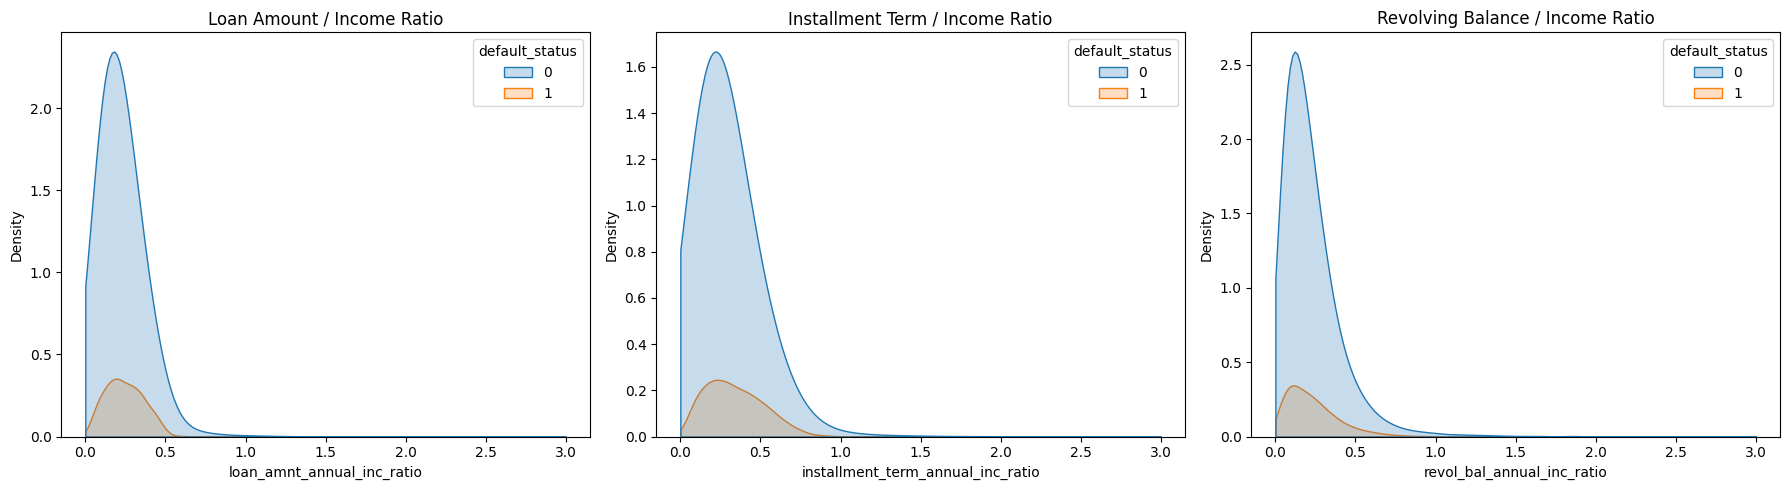

In [94]:
# Visualisation Code 
import matplotlib.pyplot as plt
import seaborn as sns

# Conventional Pyspark stratified sampling way -> Helps with class imbalance 
sample_pdf = df.select(
    col("loan_amnt_annual_inc_ratio"), 
    col("installment_term_annual_inc_ratio"), 
    col('revol_bal_annual_inc_ratio'), 
    col('default_status')
).sample(fraction=0.05, seed=42).toPandas()  

# Set up 3 subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: loan_amnt / annual_inc
sns.kdeplot(data=sample_pdf, x="loan_amnt_annual_inc_ratio", hue="default_status", ax=axes[0], fill=True, clip=(0,3))
axes[0].set_title("Loan Amount / Income Ratio")

# Plot 2: installment * term / annual_inc
sns.kdeplot(data=sample_pdf, x="installment_term_annual_inc_ratio", hue="default_status", ax=axes[1], fill=True, clip=(0,3))
axes[1].set_title("Installment Term / Income Ratio")

# Plot 3: revol_bal / annual_inc
sns.kdeplot(data=sample_pdf, x="revol_bal_annual_inc_ratio", hue="default_status", ax=axes[2], fill=True, clip=(0,3))
axes[2].set_title("Revolving Balance / Income Ratio")

plt.tight_layout()
plt.show()

Shown above, it seems that defaulters borrow less relative to income, this seems counterintuitive as it is of common belief that defaulters often borrow more than their ability to repay loans. However, this may be due to outliers in income (common in credit risk datasets), causing the right-skewness of the distributions. To observe this better, let's attempt quantile binning to reduce the impact of extreme values. 

In [95]:
from pyspark.ml.feature import QuantileDiscretizer

features_to_bin = [
    ("loan_amnt_annual_inc_ratio", "loan_amnt_annual_inc_ratio_bin"),
    ("installment_term_annual_inc_ratio", "installment_term_annual_inc_ratio_bin"),
    ("revol_bal_annual_inc_ratio", "revol_bal_annual_inc_ratio_bin")
]

for input_col, output_col in features_to_bin:
    discretizer = QuantileDiscretizer(
        numBuckets=10,
        inputCol=input_col,
        outputCol=output_col,
        handleInvalid="skip"
    )
    df = discretizer.fit(df).transform(df)

In [96]:
from pyspark.sql.functions import avg

# 1. Loan Amount / Annual Income Ratio Bin
loan_bin_stats = df.groupBy("loan_amnt_annual_inc_ratio_bin") \
    .agg(avg("default_status").alias("default_rate")) \
    .orderBy("loan_amnt_annual_inc_ratio_bin")

# 2. Installment Term / Annual Income Ratio Bin
installment_bin_stats = df.groupBy("installment_term_annual_inc_ratio_bin") \
    .agg(avg("default_status").alias("default_rate")) \
    .orderBy("installment_term_annual_inc_ratio_bin")

# 3. Revolving Balance / Annual Income Ratio Bin
revol_bin_stats = df.groupBy("revol_bal_annual_inc_ratio_bin") \
    .agg(avg("default_status").alias("default_rate")) \
    .orderBy("revol_bal_annual_inc_ratio_bin")

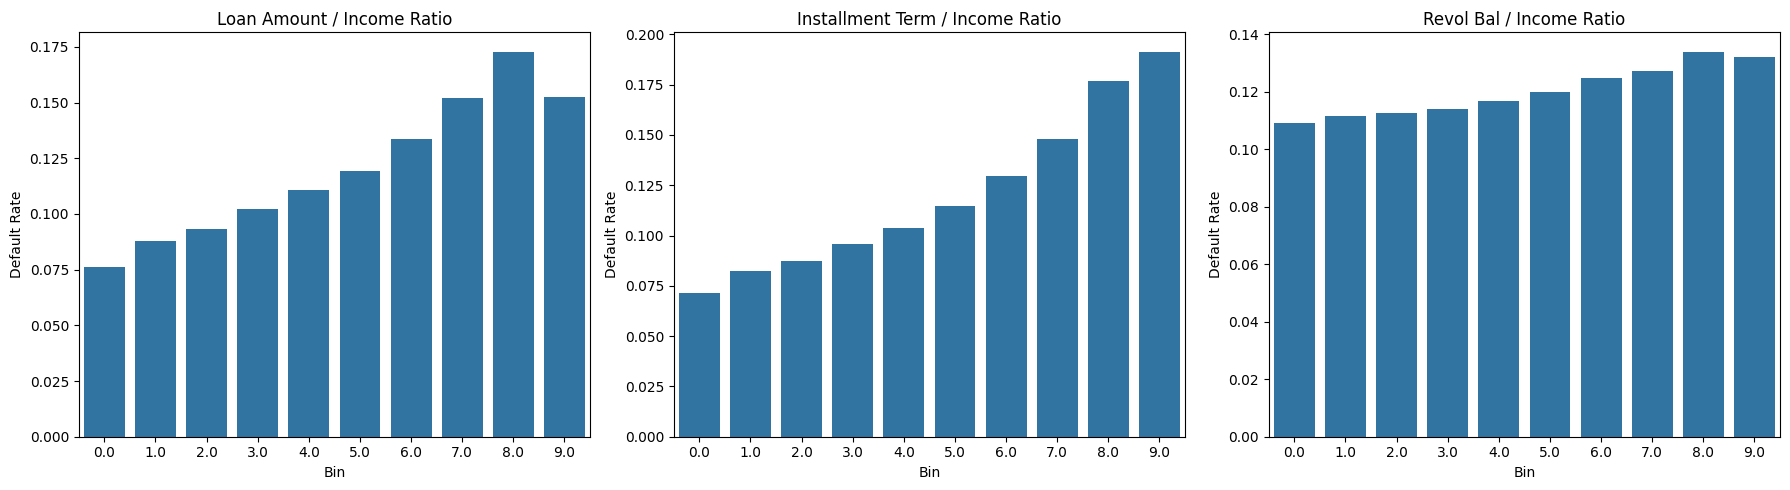

In [97]:
# Convert to Pyspark 
loan_pdf = loan_bin_stats.toPandas()
installment_pdf = installment_bin_stats.toPandas()
revol_pdf = revol_bin_stats.toPandas()

# Plot subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loan Amount Ratio
sns.barplot(data=loan_pdf, x='loan_amnt_annual_inc_ratio_bin', y='default_rate', ax=axes[0])
axes[0].set_title('Loan Amount / Income Ratio')
axes[0].set_xlabel('Bin')
axes[0].set_ylabel('Default Rate')

# Installment Ratio
sns.barplot(data=installment_pdf, x='installment_term_annual_inc_ratio_bin', y='default_rate', ax=axes[1])
axes[1].set_title('Installment Term / Income Ratio')
axes[1].set_xlabel('Bin')
axes[1].set_ylabel('Default Rate')

# Revolving Balance Ratio
sns.barplot(data=revol_pdf, x='revol_bal_annual_inc_ratio_bin', y='default_rate', ax=axes[2])
axes[2].set_title('Revol Bal / Income Ratio')
axes[2].set_xlabel('Bin')
axes[2].set_ylabel('Default Rate')

plt.tight_layout()
plt.show()


As seen from the bar charts above, the 1st 2 features are monotonic (1-directional as default rate increases). Comparatively, the last feature shows a smaller increase of default rate across bins, rendering it a less useful feature. Let's take a mental note, since WoE and IV Feature Selection would automatically detect less useful features. We will drop it at one go then. 

#### Housing Situation x Financial Stress 
Next, upon inspecting the dataset, I thought that it might be a good idea to merge `home_ownership` and other features which showcase borrower's financial capabilities to predict credit risk accurately. For example,  a borrower who has a relatively lower `annual_inc` and rents his home may have a higher credit risk, compared to someone who owns his house and have the same `annual_inc`. Let's first check if this combination is meaningful via grouping. Other features I may find meaningful will be combined with `home_ownership` as well to observe their impact on credit risk. 

In [98]:
# loan_amnt
# annual_inc 
# revol_util 

from pyspark.sql.functions import concat_ws, col

features_to_bin1 = [
    ("loan_amnt", "loan_amnt_bin"),
    ("annual_inc", "annual_inc_bin"),
    ("revol_util", "revol_util_bin")
]

for input_col, output_col in features_to_bin1:
    discretizer1 = QuantileDiscretizer(
        numBuckets=5,
        inputCol=input_col,
        outputCol=output_col,
        handleInvalid="skip"
    )
    df = discretizer1.fit(df).transform(df)


for _, binned_col in features_to_bin1:
    interaction_col = f"home_ownership_{binned_col}_interaction"
    df = df.withColumn(
        interaction_col,
        concat_ws("_", col("home_ownership"), col(binned_col).cast("string")) # delimiter, RENT, 9 -> RENT_9 for loan_amnt means high loan amount for borrower who rents his apartment ... 
    )

In [99]:
interaction_cols = [
    "home_ownership_loan_amnt_bin_interaction",
    "home_ownership_annual_inc_bin_interaction",
    "home_ownership_revol_util_bin_interaction"
]


# Calculate default status for each interaction bin 
interaction_stats = []

# For each interaction column, calculate count of default / num_records in that grp = avg() 

# Output: stats_df = home_ownership_loan_amnt_bin_interaction | default_rate
for colname in interaction_cols:
    stats_df = df.groupBy(colname) \
                  .agg(avg("default_status").alias("default_rate")) \
                  .orderBy(colname)
    
    # Add column name so we know the source later
    stats_df = stats_df.withColumnRenamed(colname, "interaction_bin") \
                       .withColumn("feature", lit(colname))
    
    interaction_stats.append(stats_df)

# Stack all interaction stats DataFrames together
combined_stats = interaction_stats[0]

for datafr in interaction_stats[1:]:
    combined_stats = combined_stats.unionByName(datafr)

# Convert to pandas
combined_pdf = combined_stats.toPandas()

combined_pdf.head()

,interaction_bin,default_rate,feature
0,MORTGAGE_0.0,0.080412,home_ownership_loan_amnt_bin_interaction
1,MORTGAGE_1.0,0.089941,home_ownership_loan_amnt_bin_interaction
2,MORTGAGE_2.0,0.113314,home_ownership_loan_amnt_bin_interaction
3,MORTGAGE_3.0,0.115898,home_ownership_loan_amnt_bin_interaction
4,MORTGAGE_4.0,0.110632,home_ownership_loan_amnt_bin_interaction


/var/folders/71/ljlh3xcn18gbcvg1hb44wqdh0000gn/T/ipykernel_22481/965987500.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/71/ljlh3xcn18gbcvg1hb44wqdh0000gn/T/ipykernel_22481/965987500.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/71/ljlh3xcn18gbcvg1hb44wqdh0000gn/T/ipykernel_22481/965987500.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


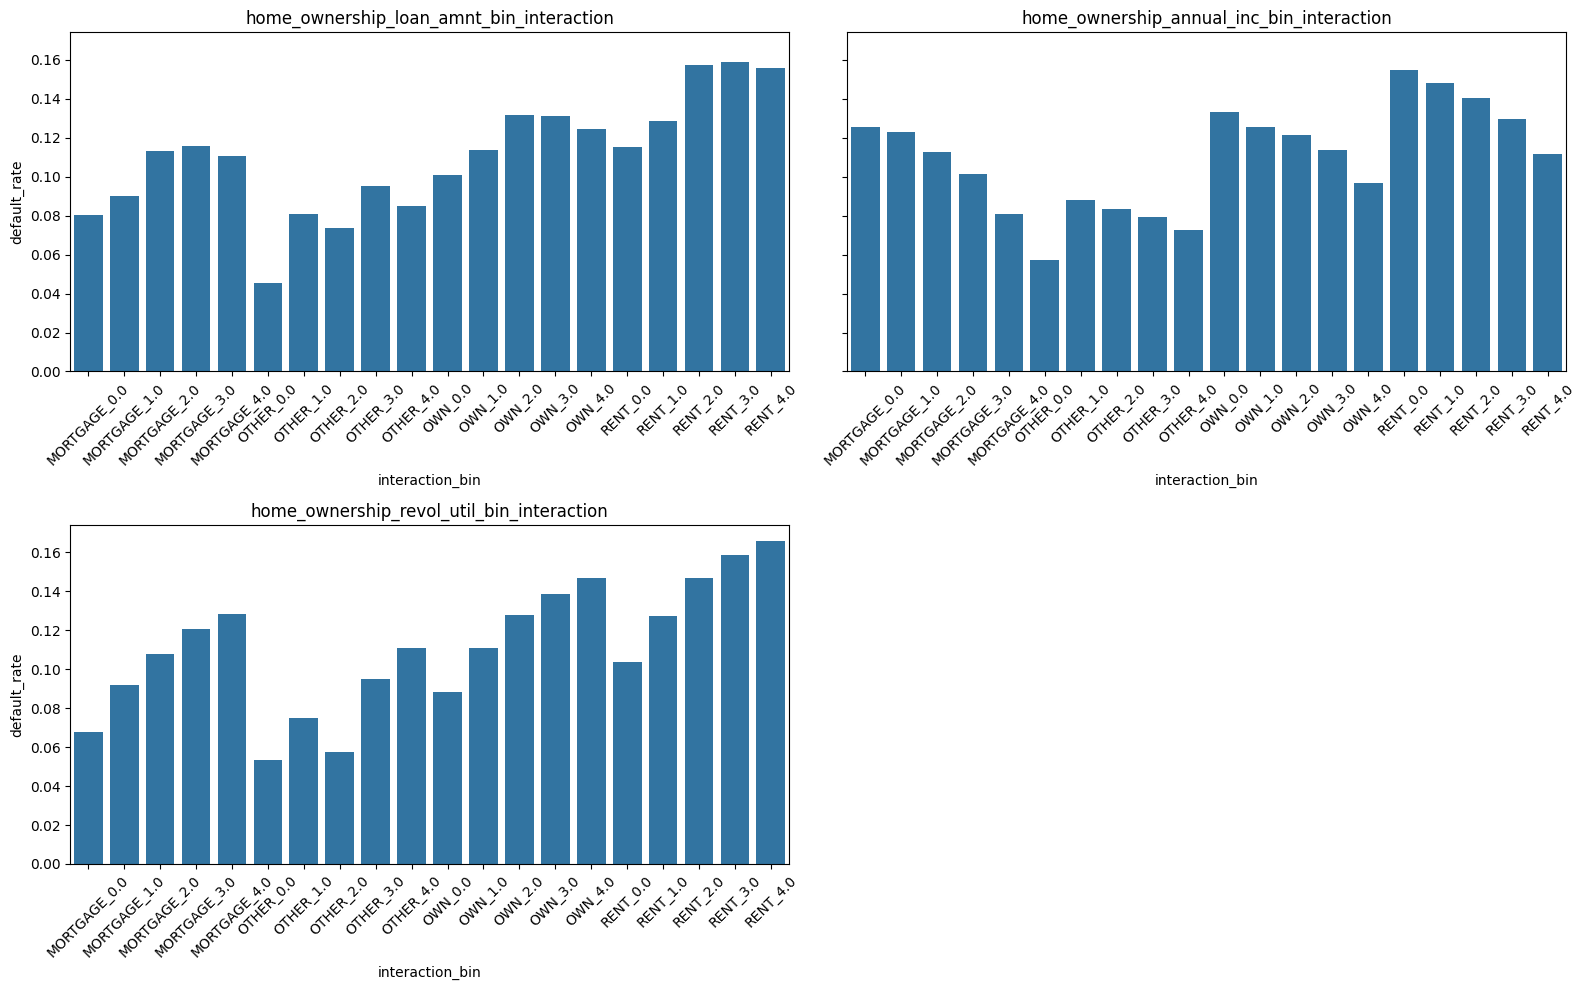

In [100]:

# Create subplot for each interaction feature
features = combined_pdf["feature"].unique()
num_plots = len(features)

fig, axes = plt.subplots(2, 2, figsize=(2 * 8 , 2 * 5), sharey=True) # each subplot will be 7 units wide, and 5 units tall, where all subplots share same y-axis 
axes = axes.flatten()  # Makes axes easier to index

for i, feature in enumerate(features):
    data = combined_pdf[combined_pdf["feature"] == feature]
    sns.barplot(data=data, x="interaction_bin", y="default_rate", ax=axes[i])
    
    # Customisation of each suplot 
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_title(features[i])

# Remove unused subplot 
for ax in axes[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()



As seen from the created interaction features (belonging to `home_ownership` category), default rate clearly differs across different combinations. They should be taken into consideration as features in our PD Model. 

#### Credit Activity 📍
Borrowers who are actively seeking for credit, yet have bad track records, such as recent delinquencies or financial stress can possibly be tracked by our model to flag risky borrowers/loans. 

In [101]:
hello = df.limit(10).toPandas()
hello 

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,revol_bal_annual_inc_ratio,loan_amnt_annual_inc_ratio_bin,installment_term_annual_inc_ratio_bin,revol_bal_annual_inc_ratio_bin,loan_amnt_bin,annual_inc_bin,revol_util_bin,home_ownership_loan_amnt_bin_interaction,home_ownership_annual_inc_bin_interaction,home_ownership_revol_util_bin_interaction
0,87023,7500.0,7500.0,36,13.75,255.43,E,0,OWN,22000.0,...,0.189773,8.0,7.0,5.0,1.0,0.0,2.0,OWN_1.0,OWN_0.0,OWN_2.0
1,90376,5000.0,5000.0,36,7.43,155.38,A,0,MORTGAGE,200000.0,...,0.428035,0.0,0.0,8.0,0.0,4.0,0.0,MORTGAGE_0.0,MORTGAGE_4.0,MORTGAGE_0.0
2,96844,5300.0,5300.0,36,8.38,167.02,A,7,MORTGAGE,74000.0,...,0.092486,0.0,0.0,2.0,0.0,2.0,0.0,MORTGAGE_0.0,MORTGAGE_2.0,MORTGAGE_0.0
3,96350,5000.0,5000.0,36,11.22,164.23,C,1,OWN,30000.0,...,0.528000,3.0,3.0,9.0,0.0,0.0,2.0,OWN_0.0,OWN_0.0,OWN_2.0
4,107136,12250.0,12250.0,36,10.59,398.69,C,3,RENT,60000.0,...,0.286900,5.0,4.0,7.0,2.0,2.0,0.0,RENT_2.0,RENT_2.0,RENT_0.0
5,90395,5000.0,5000.0,36,8.07,156.84,A,0,MORTGAGE,100000.0,...,0.096980,0.0,0.0,2.0,0.0,4.0,0.0,MORTGAGE_0.0,MORTGAGE_4.0,MORTGAGE_0.0
6,92187,2500.0,2500.0,36,8.07,78.42,A,4,MORTGAGE,110000.0,...,0.066127,0.0,0.0,1.0,0.0,4.0,0.0,MORTGAGE_0.0,MORTGAGE_4.0,MORTGAGE_0.0
7,98339,5100.0,5100.0,36,8.38,160.72,A,4,RENT,32000.0,...,0.148031,3.0,3.0,4.0,0.0,0.0,0.0,RENT_0.0,RENT_0.0,RENT_0.0
8,94838,3000.0,3000.0,36,10.28,97.20,C,2,MORTGAGE,200000.0,...,0.000000,0.0,0.0,0.0,0.0,4.0,0.0,MORTGAGE_0.0,MORTGAGE_4.0,MORTGAGE_0.0
9,92507,5000.0,5000.0,36,7.43,155.38,A,1,OWN,85000.0,...,0.002541,0.0,0.0,0.0,0.0,3.0,0.0,OWN_0.0,OWN_3.0,OWN_0.0


In [102]:
# inq_last_6mths_fico_bin
# revol_util_fico_bin
# inq_last_6mths_delinq_2yrs_bin
# inq_last_6mths_pub_rec


# Binning features
features_to_bin2 = [
    ("inq_last_6mths", "inq_last_6mths_bin"),
    ("fico_score", "fico_bin"),
    ("delinq_2yrs", "delinq_2yrs_bin"), 
    ("pub_rec", "pub_rec_bin"), 
    ('pub_rec_bankruptcies', 'pub_rec_bankruptcies_bin'),
]

for input_col, output_col in features_to_bin2:
    discretizer = QuantileDiscretizer(
        numBuckets=5,
        inputCol=input_col,
        outputCol=output_col,
        handleInvalid="skip"
    )
    df = discretizer.fit(df).transform(df)



25/07/04 14:39:37 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 3 buckets as a result.
25/07/04 14:39:38 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/04 14:39:38 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/07/04 14:39:39 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.


In [104]:
# Create interaction features for credit activity 
interaction_pairs = [
    ("inq_last_6mths_bin", "fico_bin"),
    ("revol_util_bin", "fico_bin"),
    ("inq_last_6mths_bin", "delinq_2yrs_bin"),
    ("inq_last_6mths_bin", "pub_rec_bin") , 
    ("inq_last_6mths_bin", "pub_rec_bankruptcies_bin")
]

# Create interaction features by concatenating the values of the two binned columns 
for col1, col2 in interaction_pairs:
    interaction_col = f"{col1}_{col2}_interaction"
    df = df.withColumn(
        interaction_col,
        concat_ws("_", col(col1).cast("string"), col(col2).cast("string"))
    )


25/07/04 15:31:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

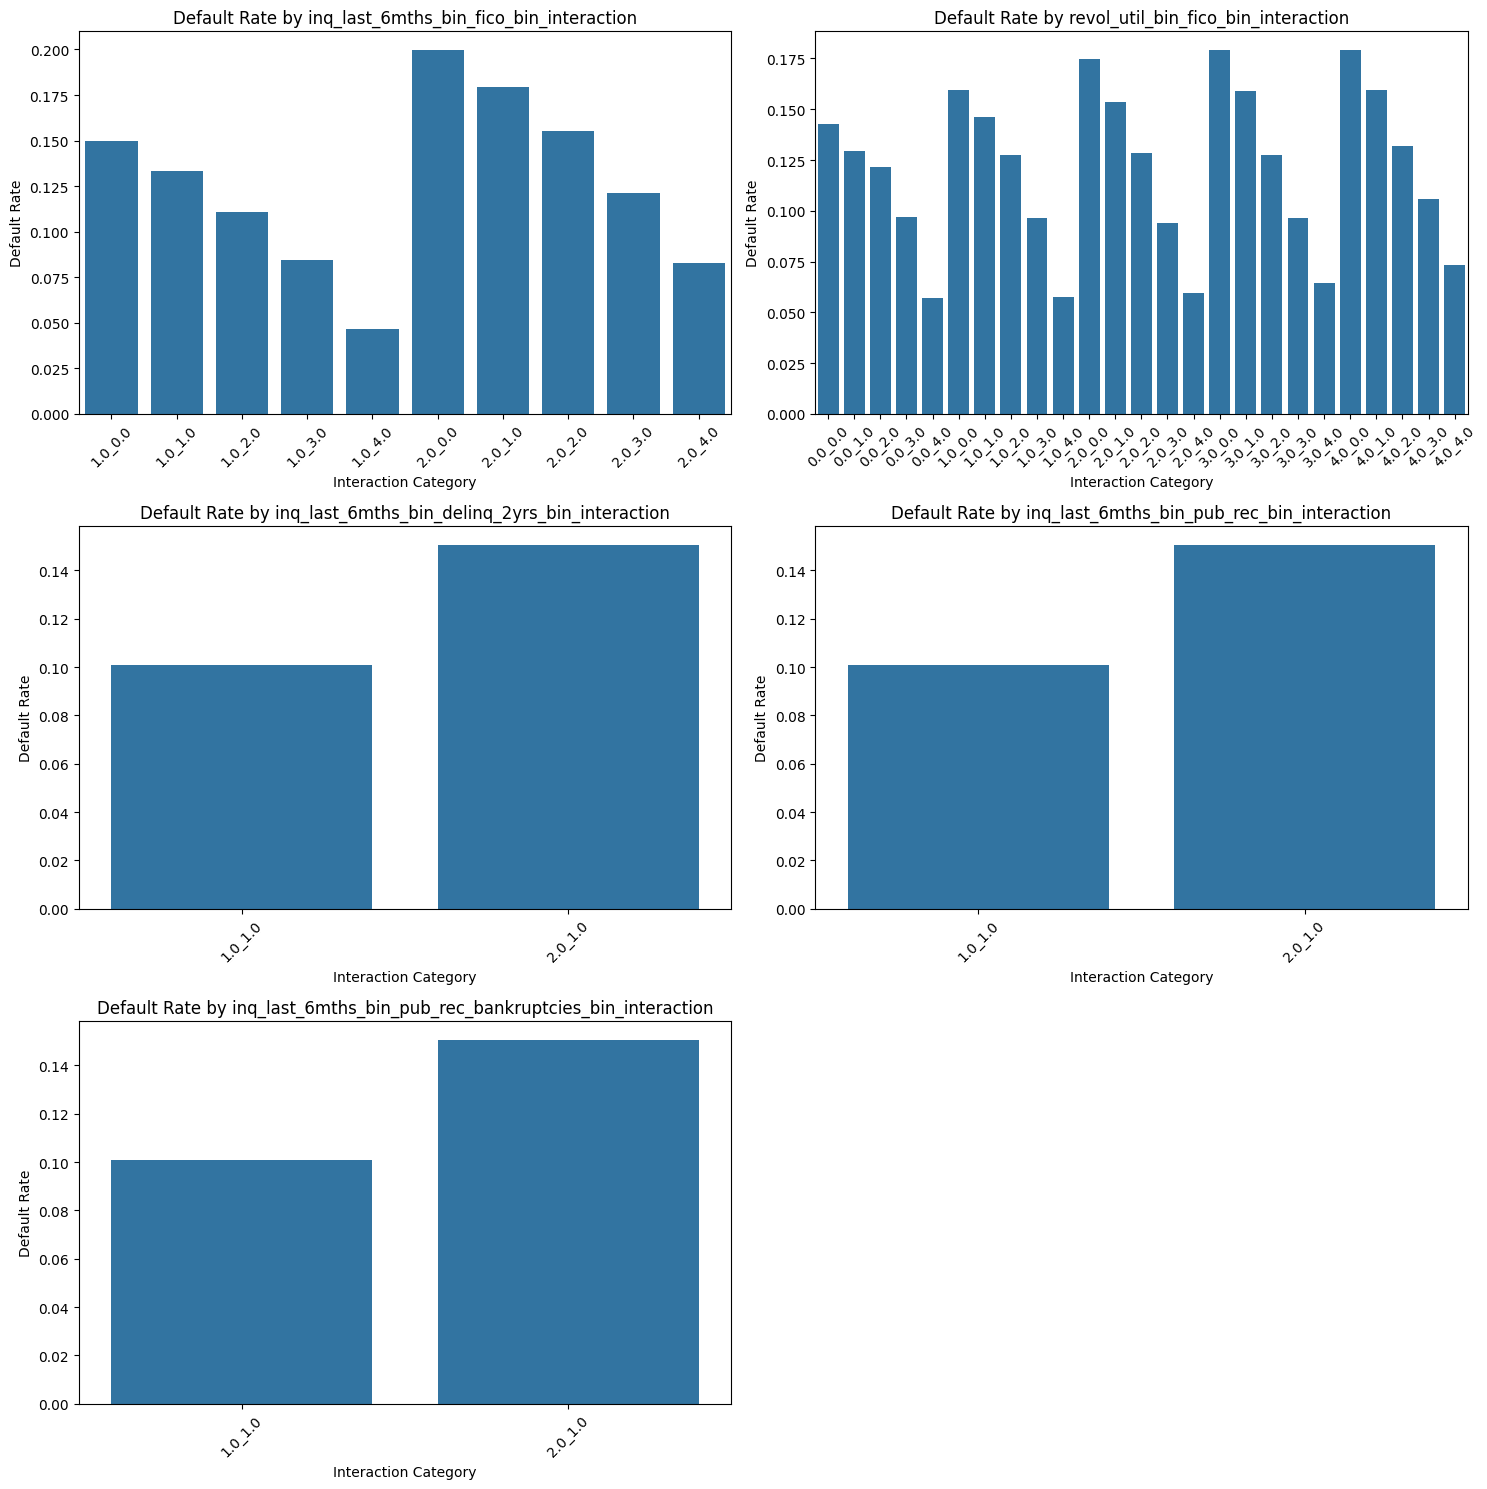

25/07/04 15:31:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [111]:
# List of interaction columns
interaction_cols = [
    f"{col1}_{col2}_interaction"
    for col1, col2 in interaction_pairs
]
import math 

# Set up the number of columns and compute rows dynamically
n_cols = 2
n_rows = math.ceil(len(interaction_cols) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten in case it's a 2D array


subplot_df_list = []

# Obtain default rate for each interaction bin 
for interaction_col in interaction_cols: 
    subplot_df = df.groupBy(interaction_col) \
      .agg(avg("default_status").alias("default_rate")) \
      .orderBy(interaction_col).toPandas()
    
    subplot_df_list.append(subplot_df)

for i, subplot_df in enumerate(subplot_df_list): 
    interaction_col = subplot_df.columns[0]  # Get the interaction column name
    sns.barplot(data=subplot_df, x=interaction_col, y="default_rate", ax=axes[i])

    # Customisation of each subplot
    axes[i].set_title(f"Default Rate by {interaction_col}")
    axes[i].set_xlabel("Interaction Category")
    axes[i].set_ylabel("Default Rate")
    axes[i].tick_params(axis='x', rotation=45)


# Remove unused subplots
for j in range(len(subplot_df_list), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


As seen above, it seems that we have found out really interesting trends that fit the real world. High number of credit inquiries, with low FICO scores have a signficantly higher default rate than the rest of the bins. Also, it seems that revolving utilisation rate doesn't add much value to one's credit risk / default rate compared to FICO bins. 

Also, it seems that higher number of inquries seem to correspond with higher default rates. Now that we have a general understanding of which features / interaction features are useful for PD Modeling, we shall leave the work to WoE/IV Feature Selection to help us identify the features which are essential for PD Modeling. 

# 2. Outlier / Skewness Detection & Treatment 

It is important to handle outliers since they create skewed distributions, which can distort credit risk models.

They can dominate learning, causing bias or overfitting. 

But in credit risk, it is important to note that some outliers (e.g., bankrupted borrowers) are important signals. Such outliers should not be blindly trimmed. 

We will first be using `approxQuantile()` method, which is a relatively more computational effective way to identify outliers for big data. This shall be used in computing the % of outliers per numerical column. 

In [14]:
def percent_outliers(df, col_name, lower_pct=0.25, upper_pct=0.75):
    # 1. Compute percentile bounds
    quantiles = df.approxQuantile(col_name, [lower_pct, upper_pct], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1 

    # 2. Obtain lower and upper bound, any data points outside of this are seen as outliers 
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    total_rows = df.count()

    return df.filter( (col(col_name) < lower_bound) | (col(col_name) > upper_bound) ).count() / total_rows * 100

# 1. After cleaning missing values, find % outliers per column 
sample_df = df_filled_missing.sample(fraction=0.05, seed=42) # Efficiency 


outliers_dict = {}

for feature in sample_df.schema: 
    col_name = feature.name 
    data_type = feature.dataType

    if isinstance(data_type, (DoubleType, IntegerType)): 
        outlier_pct = percent_outliers(sample_df, col_name) 
        if outlier_pct > 0: 
            outliers_dict[col_name] = outlier_pct
            print(f"{col_name}: {round(outlier_pct,2) }% ")


NameError: name 'df_filled_missing' is not defined

Now, we can define concrete rules on how I should deal with outliers. Rules are as shown below: 
- **Very few outliers (1 - 2%)**: Trim / Drop rows 
- **Few Outliers & Outliers are Valid but Extreme Entries**: Winsorise (Cap values)

- **High % Outliers**: Likely to be heavily right-skewed (to be transformed later on)

The goal of dropping and winsorizing is to ensure % of outliers remain slightly below 5%. To ensure these records do not skew our credit risk models, they will be transformed later on. 

In [ ]:
# 2. Save df to df1 before dealing with outliers 
df1 = df_filled_missing

In [ ]:
# 5. Check distribution for all numerical columns 
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import NumericType

# 1. Select numerical columns
numeric_cols = [field.name for field in df.schema if isinstance(field.dataType, NumericType)]

# 2. Sample small portion of data (e.g., 5%) and convert to pandas
sample_df2 = df_filled_missing.select(numeric_cols).sample(fraction=0.05, seed=42)
sample_pdf = sample_df2.toPandas()

# 3. Plot histograms as subplots
n_cols = 3  # Number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_cols):
    axes[i].hist(sample_pdf[col_name].dropna(), bins=50, color='skyblue')
    axes[i].set_title(col_name, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `default_status` cannot be resolved. Did you mean one of the following? [`loan_status`, `num_sats`, `int_rate`, `num_bc_sats`, `delinq_amnt`].;
'Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, emp_length#45648, annual_inc#52, dti#58, delinq_2yrs#59, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, total_acc#70, out_prncp#72, total_pymnt#74, total_rec_prncp#76, total_rec_int#77, total_rec_late_fee#78, recoveries#79, ... 45 more fields]
+- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
   +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
      +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
         +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
            +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
               +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                  +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                     +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                        +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                           +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                              +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                 +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                    +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                       +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                          +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                             +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                   +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                      +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                         +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                            +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                               +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                  +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                     +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                        +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                           +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                              +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                 +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                    +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                       +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                          +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                             +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                   +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                      +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                         +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                            +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                               +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                  +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                     +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                        +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, coalesce(nanvl(inq_last_6mths#63, cast(null as double)), cast(0.0 as double)) AS inq_last_6mths#48320, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                           +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, loan_status#46839, coalesce(pymnt_plan#56, cast(n as string)) AS pymnt_plan#47183, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                              +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, verification_status#46495, issue_d#54, coalesce(loan_status#55, cast(Fully Paid as string)) AS loan_status#46839, pymnt_plan#56, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                                 +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, home_ownership#45992, annual_inc#52, coalesce(verification_status#53, cast(Source Verified as string)) AS verification_status#46495, issue_d#54, loan_status#55, pymnt_plan#56, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                                    +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, emp_length#45648, coalesce(home_ownership#51, cast(MORTGAGE as string)) AS home_ownership#45992, annual_inc#52, verification_status#53, issue_d#54, loan_status#55, pymnt_plan#56, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                                       +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#45147, coalesce(emp_length#50, cast(6.0 as int)) AS emp_length#45648, home_ownership#51, annual_inc#52, verification_status#53, issue_d#54, loan_status#55, pymnt_plan#56, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                                          +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, coalesce(grade#47, cast(B as string)) AS grade#45147, emp_length#50, home_ownership#51, annual_inc#52, verification_status#53, issue_d#54, loan_status#55, pymnt_plan#56, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                                             +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#47, emp_length#50, home_ownership#51, annual_inc#52, verification_status#53, issue_d#54, loan_status#55, pymnt_plan#56, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 53 more fields]
                                                                                                                                                +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#47, emp_length#50, home_ownership#51, annual_inc#52, verification_status#53, issue_d#54, loan_status#55, pymnt_plan#56, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, open_acc#66, pub_rec#67, revol_bal#68, revol_util#69, ... 57 more fields]
                                                                                                                                                   +- Project [id#39, loan_amnt#41, funded_amnt#42, term#44, int_rate#45, installment#46, grade#47, emp_title#49, emp_length#50, home_ownership#51, annual_inc#52, verification_status#53, issue_d#54, loan_status#55, pymnt_plan#56, addr_state#57, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, open_acc#66, pub_rec#67, ... 59 more fields]
                                                                                                                                                      +- Project [id#39, loan_amnt#41, funded_amnt#42, funded_amnt_inv#43, term#44, int_rate#45, installment#46, grade#47, sub_grade#48, emp_title#49, emp_length#50, home_ownership#51, annual_inc#52, verification_status#53, issue_d#54, loan_status#55, pymnt_plan#56, addr_state#57, dti#58, delinq_2yrs#59, earliest_cr_line#60, fico_range_low#61, fico_range_high#62, inq_last_6mths#63, ... 65 more fields]
                                                                                                                                                         +- Relation [id#39,member_id#40,loan_amnt#41,funded_amnt#42,funded_amnt_inv#43,term#44,int_rate#45,installment#46,grade#47,sub_grade#48,emp_title#49,emp_length#50,home_ownership#51,annual_inc#52,verification_status#53,issue_d#54,loan_status#55,pymnt_plan#56,addr_state#57,dti#58,delinq_2yrs#59,earliest_cr_line#60,fico_range_low#61,fico_range_high#62,... 122 more fields] parquet


In [ ]:

# 3. Perform trimming & winsorisation 
def winsorize_column(df, col_name, lower_pct=0.25, upper_pct=0.75):
    # Get lower and upper bounds
    bounds = df.approxQuantile(col_name, [lower_pct, upper_pct], 0.01)
    lower, upper = bounds[0], bounds[1]

    # Apply winsorization
    return df.withColumn(
        col_name,  
        when(col(col_name) < lower, lower)
        .when(col(col_name) > upper, upper)
        .otherwise(col(col_name))
    )

# Debug: ensure dictionary is not empty
print(f"🧮 Total columns with outliers: {len(outliers_dict)}\n")

# Iterate over each column in outliers_dict
for col_name in outliers_dict.keys(): 
    pct = outliers_dict[col_name]

    if 0 < pct <= 1:
        print(f"✅ Dropping rows with outliers in {col_name} ({round(pct, 2)}%) ...")
        q1, q3 = df1.approxQuantile(col_name, [0.25, 0.75], 0.01)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df1 = df1.filter((col(col_name) >= lower) & (col(col_name) <= upper))

    elif 1 < pct <= 5:
        print(f"✅ Winsorizing {col_name} ({round(pct, 2)}%) ...")
        df1 = winsorize_column(df1, col_name)

    else:
        print(f"🚩 Skipping {col_name} ({round(pct, 2)}%) — too many outliers ...")



🧮 Total columns with outliers: 63

✅ Winsorizing loan_amnt (1.55%) ...
✅ Winsorizing funded_amnt (1.55%) ...
✅ Winsorizing int_rate (2.6%) ...
✅ Winsorizing installment (3.52%) ...
✅ Winsorizing annual_inc (4.94%) ...
✅ Dropping rows with outliers in dti (0.93%) ...
🚩 Skipping delinq_2yrs (18.66%) — too many outliers ...
✅ Winsorizing fico_range_low (3.4%) ...
✅ Winsorizing fico_range_high (3.4%) ...
✅ Winsorizing inq_last_6mths (4.09%) ...
✅ Winsorizing open_acc (3.74%) ...
🚩 Skipping pub_rec (15.8%) — too many outliers ...
🚩 Skipping revol_bal (6.42%) — too many outliers ...
✅ Winsorizing total_acc (1.75%) ...
🚩 Skipping out_prncp (10.29%) — too many outliers ...
✅ Winsorizing total_pymnt (4.01%) ...
✅ Winsorizing total_rec_prncp (4.03%) ...
🚩 Skipping total_rec_int (7.72%) — too many outliers ...
✅ Winsorizing total_rec_late_fee (3.87%) ...
🚩 Skipping recoveries (8.18%) — too many outliers ...
🚩 Skipping collection_recovery_fee (7.82%) — too many outliers ...
🚩 Skipping last_pymnt_a

In [ ]:
# 4. Check for outlier % again 
sample_df1 = df1.sample(fraction=0.05, seed=42) # Efficiency 

for feature in df1.schema: 
    col_name = feature.name 
    data_type = feature.dataType

    if isinstance(data_type, (DoubleType, IntegerType)): 
        outlier_pct = percent_outliers(df1, col_name) 
        if outlier_pct > 0: 
            print(f"{col_name}: {round(outlier_pct,2) }% ")

dti: 0.02% 
delinq_2yrs: 17.88% 
pub_rec: 15.92% 
revol_bal: 6.18% 
out_prncp: 9.86% 
total_rec_int: 7.65% 
recoveries: 8.19% 
collection_recovery_fee: 7.82% 
last_pymnt_amnt: 13.86% 
tot_coll_amt: 14.85% 
total_rev_hi_lim: 6.09% 
avg_cur_bal: 5.86% 
bc_open_to_buy: 8.77% 
bc_util: 0.0% 
mo_sin_old_il_acct: 5.48% 
mo_sin_rcnt_rev_tl_op: 7.43% 
mo_sin_rcnt_tl: 6.67% 
mths_since_recent_bc: 9.64% 
mths_since_recent_inq: 3.09% 
num_accts_ever_120_pd: 21.75% 
num_tl_90g_dpd_24m: 4.56% 
pct_tl_nvr_dlq: 7.17% 
pub_rec_bankruptcies: 12.12% 
total_bal_ex_mort: 6.2% 
total_bc_limit: 6.18% 
total_il_high_credit_limit: 5.34% 


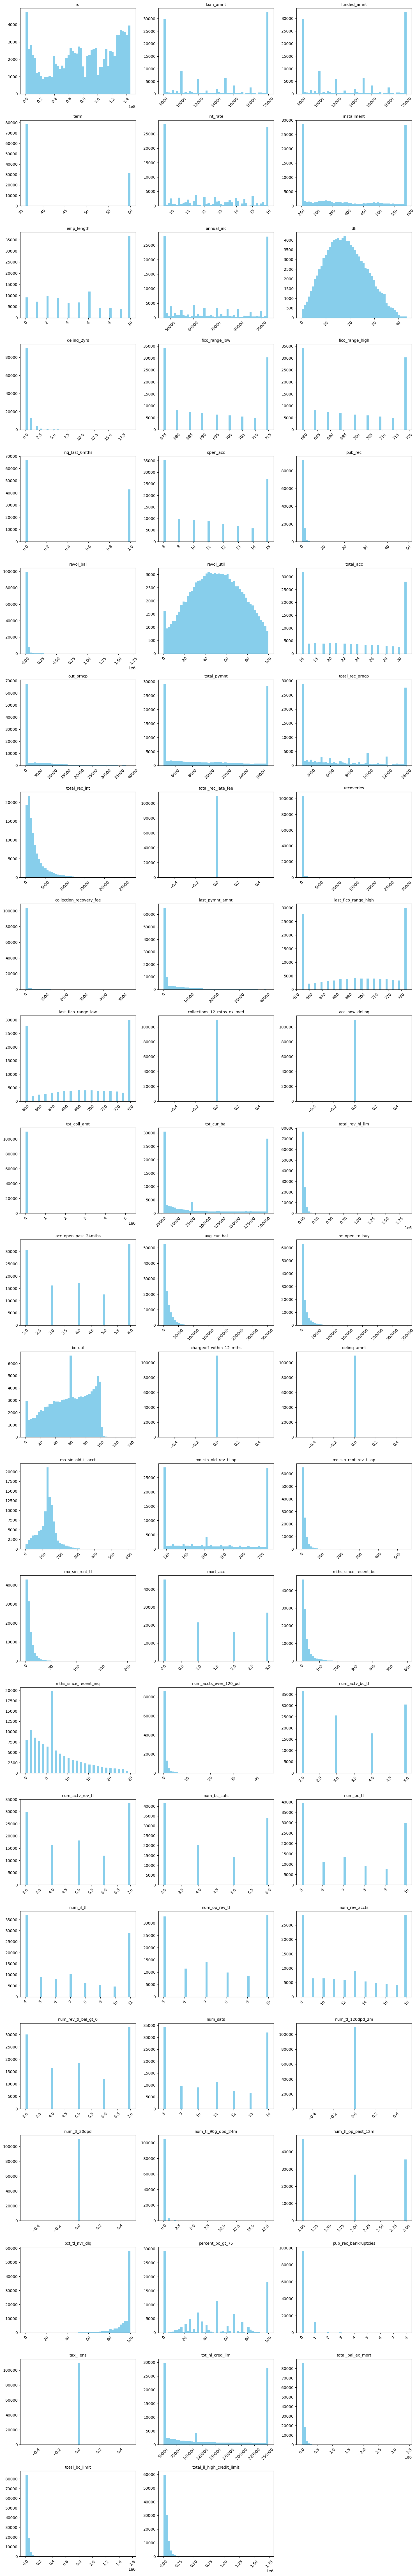

In [ ]:
# 5. Check distribution for all numerical columns 
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import NumericType

# 1. Select numerical columns
numeric_cols = [field.name for field in df.schema if isinstance(field.dataType, NumericType)]

# 2. Sample small portion of data (e.g., 5%) and convert to pandas
sample_df2 = df1.select(numeric_cols).sample(fraction=0.05, seed=42)
sample_pdf = sample_df2.toPandas()

# 3. Plot histograms as subplots
n_cols = 3  # Number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_cols):
    axes[i].hist(sample_pdf[col_name].dropna(), bins=50, color='skyblue')
    axes[i].set_title(col_name, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
df.limit(100).toPandas()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,44107057,11500.0,11500.0,60,18.25,293.60,E,6,RENT,25000.0,...,0.0,2.0,100.0,20.0,0.0,0.0,24200.0,10307.0,16300.0,0.0
1,47038475,12000.0,12000.0,36,6.92,370.09,A,6,RENT,53900.0,...,0.0,5.0,100.0,0.0,0.0,0.0,212844.0,79756.0,89700.0,36144.0
2,44613469,32000.0,32000.0,60,13.99,744.42,C,6,MORTGAGE,88000.0,...,0.0,1.0,80.0,100.0,0.0,0.0,36700.0,25736.0,17000.0,0.0
3,43570106,17000.0,17000.0,60,10.99,369.54,B,6,MORTGAGE,49378.8,...,0.0,2.0,100.0,100.0,0.0,0.0,193352.0,34738.0,16800.0,21052.0
4,44986522,4375.0,4375.0,36,16.55,155.01,D,6,MORTGAGE,48180.0,...,0.0,3.0,71.0,66.7,1.0,0.0,19824.0,4318.0,3750.0,15374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45534910,17400.0,17400.0,36,12.29,580.35,C,6,MORTGAGE,39684.0,...,0.0,1.0,93.1,60.0,0.0,0.0,161013.0,52933.0,32700.0,46762.0
96,43956708,4200.0,4200.0,36,14.65,144.88,C,6,MORTGAGE,50000.0,...,0.0,0.0,96.0,83.3,1.0,0.0,168220.0,45459.0,11900.0,52920.0
97,44087120,25000.0,25000.0,60,14.65,590.17,C,6,MORTGAGE,61000.0,...,0.0,4.0,95.2,37.5,0.0,0.0,113900.0,29191.0,41800.0,0.0
98,44329959,9000.0,9000.0,36,10.99,294.61,B,6,OWN,48700.0,...,0.0,1.0,91.7,50.0,1.0,1.0,76650.0,7383.0,5800.0,4550.0


### 5.1 Peform Feature Transformation (Skewness)
We will group the following numerical features into the following categories: 
- **Weird Bimodal Distributions**: Avoid over-transforming them since this reflects real-world extreme borrowers' behaviour / demographics
- **Highly Right Skewed (Continuous)**: Perform log transformation (if skewness issue is unsolved, utilise Box-Cox)
- **Highly Right Skewed (Pct / Probability)**: Logit Transformation
- **Left Skewed Variables**: Use Power / Exponential Transformations
- **Already Categorical**: Features such as `term` are already discrete by nature, and should not be transformed, at most encoded 

# 3. Feature Selection 

### 3.2 Mitigate Data Leak 
In credit risk modeling, there are normally features in the dataset, which 'tells our model' the answer, when it should not. Put simply, these are features that hint to the model that the borrower has defaulted in the corresponding record. This is termed as 'data leak' in the data realm and should not happen, since machine learning models are meant to predict the future, using past data. Similarly, we are trying to utilise features known at the time of loan origination, to predict a borrower's / loan's probability of default. 

In [0]:
# post_loan_origination_features = ['out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'mths_since_recent_bc', 'mths_since_recent_inq']
# df = df.drop(*post_loan_origination_features) # Final Loan Balaance ? 
# print('✅ Post Loan Origination Features Dropped ...')

### Standardisation

### Encoding Categorical Variables 

## Dataset Imbalance Handling